# Testing Notebook

## Imports

In [1]:
# %load ~/dev/marthaler/header.py
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

from dataclasses import dataclass
from typing import Dict, Any, Tuple
from datetime import datetime, timedelta

import warnings

plt.style.use("ggplot")
warnings.filterwarnings('ignore')

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rc('figure', figsize=(16, 10))
plt.rc('font', size=14)


In [2]:
import math

import equinox as eqx
import jax
from jax import vmap
import jax.lax as lax
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
import optax  # https://github.com/deepmind/optax
import torch

In [3]:
from jaxtyping import Array, Float, Int, PyTree  # https://github.com/google/jaxtyping

In [5]:
from typing import Sequence, Union

In [4]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

cpu


## Functions

In [6]:
def shift_image(
    img: np.ndarray[np.uint8],
    horizontal_shift: int,
    vertical_shift: int,
)->np.ndarray[np.uint8]:
    """
      Function to shift an image by fixed numbers of pixels and fill in with 0.
      
      The image origin in numpy are at the top-left corner so to get a positive
      vertical shift, we need to negate the vertical shift value passed in.
      
      :param img: The input image
      :type img: np.ndarray[np.uint8]
      :param horizontal_shift: the number of pixels to shift horizontally
      :type horizontal_shift: int
      :param vertical_shift: the number of pixels to shift vertically
      :type vertical_shift: int
      :return: The shifted image
      :rtype: np.ndarray[np.uint8]
    """
    # Negate the vertical shift to compensate for the origin at the top-left of image
    vertical_shift = -vertical_shift
    shift_img = np.roll(img, vertical_shift, axis=0)
    shift_img = np.roll(shift_img, horizontal_shift, axis=1)
    if vertical_shift>0:
        shift_img[:vertical_shift, :] = 0
    elif vertical_shift<0:
        shift_img[vertical_shift:, :] = 0
    if horizontal_shift>0:
        shift_img[:, :horizontal_shift] = 0
    elif horizontal_shift<0:
        shift_img[:, horizontal_shift:] = 0
    return shift_img

In [11]:
from einops import rearrange

#x = jnp.arange(5 * 8 * 8 * 3).reshape(5, 8, 8, 3)
#pixel_shuffle(x) = print(x.shape) # (5, 4, 4, 12)
# pixel_unshuffle(pixel_shuffle(x)) = print(x.shape) # (5, 8, 8, 3)

# Space to depth
def pixel_shuffle(x: Float[Array, '...']):
    """Performs the pytorch PixelShuffle function.
      This implementation was taken from a 
      [discussion](https://github.com/google/flax/discussions/2899) in flax
    """
    return rearrange(x, '... (h b1) (w b2) c -> ... h w (c b1 b2)', b1=2, b2=2)


# Depth to space
def pixel_unshuffle(x: Float[Array, '...']):
    """Performs the pytorch PixelUnShuffle function.
      This implementation was taken from a 
      [discussion](https://github.com/google/flax/discussions/2899) in flax
    """
    return rearrange(x, '... h w (c b1 b2) -> ... (h b1) (w b2) c', b1=2, b2=2)


In [160]:
class BasicConv2d(eqx.Module):
    act_norm: bool
    conv: list
    norm: eqx.nn.GroupNorm
    act: jax.nn.silu

    def __init__(
        self,
        key: jax.random.PRNGKey,
        in_channels: int,
        out_channels: int,
        kernel_size: Union[int, Sequence[int]]=3,
        stride: Union[int, Sequence[int]]=1,
        padding: Union[str, int, Sequence[int]]=0,
        dilation: Union[str, int, Sequence[int]]=1,
        upsampling: bool=False,
        act_norm: bool=False,
        act_inplace: bool=True,
    )->None:
        super(BasicConv2d, self).__init__()
        self.act_norm = act_norm
        if upsampling is True:
            self.conv = eqx.nn.Sequential([*[
                eqx.nn.Conv2d(in_channels, out_channels*4, kernel_size=kernel_size,
                          stride=1, padding=padding, dilation=dilation, key=key),
                pixel_shuffle
            ]])
        else:
            self.conv = eqx.nn.Conv2d(
                in_channels, out_channels, kernel_size=kernel_size,
                stride=stride, padding=padding, dilation=dilation,key=key)
            
        self.norm = eqx.nn.GroupNorm(2, out_channels)
        self.act = jax.nn.silu

        #self.apply(self._init_weights)

#     def _init_weights(self, m):
#         if isinstance(m, (eqx.nn.Conv2d)):
#             m.weight = jax.nn.initializers.truncated_normal(m.weight, stddev=.02, lower=-2.0, upper=2.0)
#             m.bias = jax.nn.initializers.constant(m.bias.shape, 0)
        
    def __call__(self, x):
        y = self.conv(x)
        if self.act_norm:
            y = self.act(self.norm(y))
        return y


In [161]:
SEED = 5678

key = jax.random.PRNGKey(SEED)

In [162]:
class ConvSC(eqx.Module):
    conv: eqx.nn.Conv
    def __init__(
        self,
        key: jax.random.PRNGKey,
        C_in: int,
        C_out: int,
        kernel_size: int=3,
        downsampling=False,
        upsampling=False,
        act_norm: bool=True
    )->None:
        super(ConvSC, self).__init__()

        stride = 2 if downsampling is True else 1
        padding = (kernel_size - stride + 1) // 2

        self.conv = BasicConv2d(
            key,
            C_in, 
            C_out, 
            kernel_size=kernel_size, 
            stride=stride,
            upsampling=upsampling,
            padding=padding,
            act_norm=act_norm
        )

    def __call__(self, x):
        y = self.conv(x)
        return y

In [163]:
from jaxtyping import Array, Float, Int, PyTree  # https://github.com/google/jaxtyping
def sampling_generator(N:int, reverse:bool=False)->list:
    samplings = [False, True] * (N // 2)
    if reverse: 
        return list(reversed(samplings[:N]))
    else: 
        return samplings[:N]

class Encoder(eqx.Module):
    """3D Encoder for SimVP"""
    enc: list

    def __init__(
        self,
        key: jax.random.PRNGKey,
        C_in: int,
        C_hid: int, 
        N_S: int, 
        spatio_kernel: int,
    )->None:
        super(Encoder, self).__init__()
        samplings = sampling_generator(N_S)
        keys = jax.random.split(key, N_S)
        self.enc = eqx.nn.Sequential([
              ConvSC(keys[0], C_in, C_hid, spatio_kernel, downsampling=samplings[0],),
            *[ConvSC(k,C_hid, C_hid, spatio_kernel, downsampling=s) for k,s in zip(keys[1:],samplings[1:])]
        ]
        )
        
    def __call__(self, x: Float[Array, "1 64 64"])->Float[Array, "1 16 16"]:
        enc1 = self.enc[0](x)
        latent = enc1
        for i in range(1, len(self.enc)):
            latent = self.enc[i](latent)
        return latent, enc1

In [164]:
hid_S=16
hid_T=256
N_S=4
N_T=4

In [165]:
in_shape

[10, 1, 64, 64]

In [166]:
T, C, H, W = tuple(in_shape)
enc = Encoder(key, C, hid_S, N_S, 3)

In [167]:
B, T, C, H, W = x_batch.shape
x = x_batch.reshape(B*T, C, H, W)

In [168]:
embed = vmap(enc)(x)

In [169]:
embed[0].shape, embed[1].shape

((160, 16, 16, 16), (160, 16, 64, 64))

In [170]:
class Decoder(eqx.Module):
    """3D Decoder for SimVP"""
    readout: eqx.nn.Conv2d
    dec: list

    def __init__(
        self,
        key: jax.random.PRNGKey,
        C_hid: int,
        C_out: int, 
        N_S: int,
        spatio_kernel: int,
    )->None:
        super(Decoder, self).__init__()
        samplings = sampling_generator(N_S, reverse=True)
        keys = jax.random.split(key, N_S+1)
        self.dec = eqx.nn.Sequential([
            *[ConvSC(k, C_hid, C_hid, spatio_kernel, upsampling=s,) for k,s in zip(keys[:-2],samplings[:-1])],
              ConvSC(keys[-2],C_hid, C_hid, spatio_kernel, upsampling=samplings[-1])
        ])

        self.readout = eqx.nn.Conv2d(C_hid, C_out, 1, key=keys[-1],)

    def __call__(self, hid, enc1=None):
        for i in range(0, len(self.dec)-1):
            hid = self.dec[i](hid)
        Y = self.dec[-1](hid+enc1)
        return self.readout(Y)

In [171]:
dec = Decoder(key, hid_S, C, N_S, 3)

In [174]:
vmap(dec)(embed)

AttributeError: 'tuple' object has no attribute 'ndim'

In [32]:
class ExactDecoder(eqx.Module):
    readout: eqx.nn.Conv2d
    dec: list

    def __init__(
        self,
        num_features: int,
        num_out_features: int,
        num_layers: int,
        enc: Encoder
    )->None:
        super(ExactDecoder, self).__init__()
        cnn_t = eqx.nn.ConvTranspose2d(num_features, num_features, kernel_size=3, key=key, stride=2, padding=1, output_padding=1)
        cnn_t = eqx.tree_at(
            lambda x: x.weight, cnn_t, jnp.flip(
                enc.enc[-1].weight,axis=tuple(range(2, enc.enc[-1].weight.ndim))
            ).swapaxes(0, 1)
        )
        self.dec = [cnn_t]
        for i in range(1,num_layers-1):
            cnn_t = eqx.nn.ConvTranspose2d(num_features, num_features, kernel_size=3, stride=2, key=keys[i], padding=1, output_padding=1)
            cnn_t = eqx.tree_at(
                lambda x: x.weight, cnn_t, jnp.flip(
                    enc.enc[-1-i].weight,axis=tuple(range(2, enc.enc[-1-i].weight.ndim))
                ).swapaxes(0, 1)
            )
            self.dec.append(cnn_t)

        self.readout = eqx.nn.ConvTranspose2d(num_features, num_out_features,kernel_size=3, stride=2, key=keys[-1], padding=1, output_padding=1)
        self.readout = eqx.tree_at(lambda x: x.weight, self.readout, jnp.flip(enc.enc[0].weight,axis=tuple(range(2, enc.enc[0].weight.ndim))).swapaxes(0, 1))
    def __call__(self, hid, enc1=None):
        for i in range(0, len(self.dec)):
            hid = self.dec[i](hid)
        return self.readout(hid)

In [33]:
class SimVP(eqx.Module):
    enc: Encoder
    dec: Decoder
    def __init__(
        self,
        shape_in,
        key: jax.random.PRNGKey,
        hid_S: int=16,
        num_layers: int=4,
    ):
        super(SimVP, self).__init__()
        T, C, H, W = shape_in
        keys = jax.random.split(key, 2)
        self.enc = Encoder(C, hid_S, num_layers, keys[0])
        self.dec = Decoder(hid_S, C, num_layers, keys[1])



    def __call__(self, x_raw):
        B, T, C, H, W = x_raw.shape
        x = x_raw.reshape(B*T, C, H, W)

        embed = vmap(self.enc)(x)
        return vmap(self.dec)(embed).reshape(B, T, C, H, W)

## Load Image Data

In [16]:
imgs = np.load('/Users/daniel.marthaler/dev/SimVP/data/moving_mnist/mnist_test_seq.npy')

In [17]:
imgs.shape

(20, 10000, 64, 64)

In [18]:
type(imgs[0,0,:,:]), type(imgs[0,0,0,0])

(numpy.ndarray, numpy.uint8)

In [15]:
#plt.imshow(imgs[0,0,:,:]);

In [16]:
# Shift image
#plt.imshow(shift_image(imgs[0,0,:,:],-20,10));

## Parameters

In [21]:
seed = 42
batch_size = 16
val_batch_size=16
num_workers=8

# model parameters
in_shape=[10, 1, 64, 64]  
hid_S=64
hid_T=256
num_layers=3
N_T=8
groups=4

# Training parameters
epochs=1000
log_step=1
lr=0.01

In [22]:
# Hyperparameters

BATCH_SIZE = 64
LEARNING_RATE = 3e-4
STEPS = 300
PRINT_EVERY = 30
SEED = 5678

key = jax.random.PRNGKey(SEED)

## Model

In [19]:
from dataloader_moving_mnist import load_data

In [34]:
model = SimVP(tuple(in_shape), key, hid_S, num_layers)

In [23]:
train_loader, vali_loader, test_loader, data_mean, data_std = load_data(
    batch_size,
    val_batch_size,
    '/Users/daniel.marthaler/dev/SimVP/data',
    num_workers
)

In [35]:
def compute_loss(model, x, y):
    pred_y = model(x)
    # Trains with respect to huber loss
    return optax.losses.huber_loss(pred_y, y).sum()
loss = eqx.filter_jit(compute_loss)

In [36]:
def evaluate(model: SimVP, testloader: torch.utils.data.DataLoader):
    """This function evaluates the model on the test dataset,
    computing both the average loss and the average accuracy.
    """
    avg_loss = 0
    for x, y in testloader:
        x = x.numpy()
        y = y.numpy()
        # Note that all the JAX operations happen inside `loss` and `compute_accuracy`,
        # and both have JIT wrappers, so this is fast.
        avg_loss += loss(model, x, y)
    return avg_loss / len(testloader)

In [37]:
#evaluate(model, test_loader)

In [38]:
optim = optax.adamw(LEARNING_RATE)

In [41]:
def train(
    model: SimVP,
    trainloader: torch.utils.data.DataLoader,
    testloader: torch.utils.data.DataLoader,
    optim: optax.GradientTransformation,
    steps: int,
    print_every: int,
) -> SimVP:
    # Just like earlier: It only makes sense to train the arrays in our model,
    # so filter out everything else.
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    # Always wrap everything -- computing gradients, running the optimiser, updating
    # the model -- into a single JIT region. This ensures things run as fast as
    # possible.
    @eqx.filter_jit
    def make_step(
        model: SimVP,
        opt_state: PyTree,
        x: Float[Array, "batch 10 1 64 64"],
        y: Float[Array, "batch 10 1 64 64"],
    ):
        loss_value, grads = eqx.filter_value_and_grad(loss)(model, x, y)
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    # Loop over our training dataset as many times as we need.
    def infinite_trainloader():
        while True:
            yield from trainloader

    for step, (x, y) in zip(range(steps), infinite_trainloader()):
        # PyTorch dataloaders give PyTorch tensors by default,
        # so convert them to NumPy arrays.
        x = x.numpy()
        y = y.numpy()
        model, opt_state, train_loss = make_step(model, opt_state, x, y)
        if (step % print_every) == 0 or (step == steps - 1):
            test_loss = evaluate(model, testloader)
            print(
                f"{step}, train_loss={train_loss.item()}, test_loss={test_loss.item()}"
            )
    return model

In [42]:
model = train(model, train_loader, test_loader, optim, STEPS, PRINT_EVERY)

0, train_loss=15147.533203125, test_loss=15578.0703125
30, train_loss=12812.1455078125, test_loss=12844.263671875
60, train_loss=12932.6796875, test_loss=12728.06640625
90, train_loss=13780.23828125, test_loss=12668.1640625
120, train_loss=12963.267578125, test_loss=12656.1806640625
150, train_loss=12216.443359375, test_loss=12720.783203125
180, train_loss=11304.201171875, test_loss=12651.8193359375
210, train_loss=12179.1328125, test_loss=12663.41015625
240, train_loss=12372.5595703125, test_loss=12647.3916015625
270, train_loss=11783.666015625, test_loss=12659.9921875
299, train_loss=12628.9033203125, test_loss=12662.6572265625


In [46]:
def infinite_trainloader():
    while True:
        yield from train_loader

In [24]:
x_batch, y_batch = next(iter(train_loader))

In [25]:
x_batch = x_batch.numpy()
y_batch = y_batch.numpy()

In [54]:
y_pred = model(x_batch)

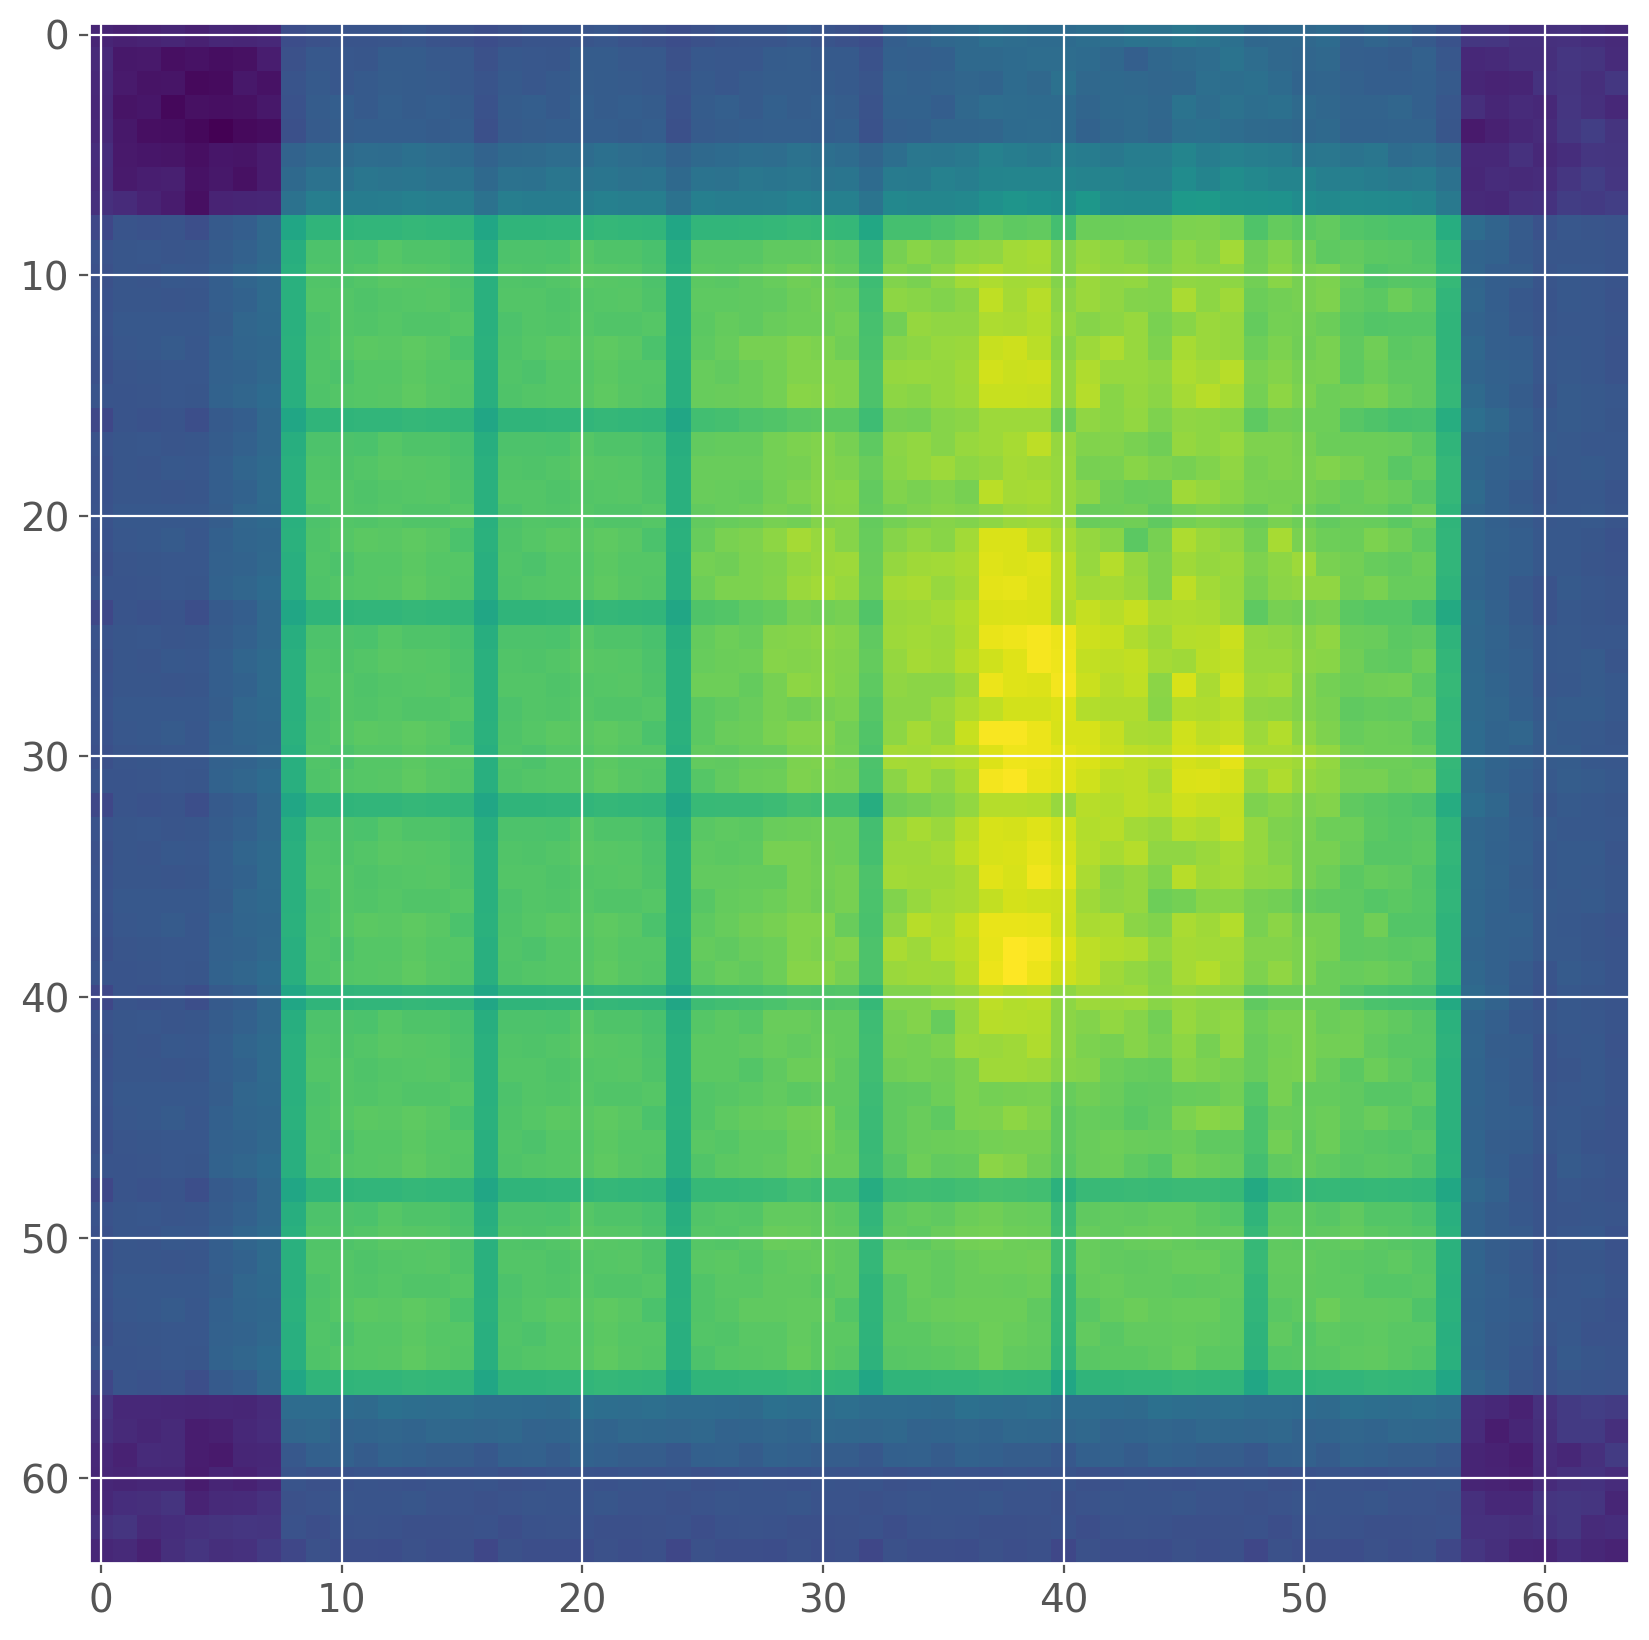

In [55]:
plt.imshow(y_pred[0,0,0,:,:])

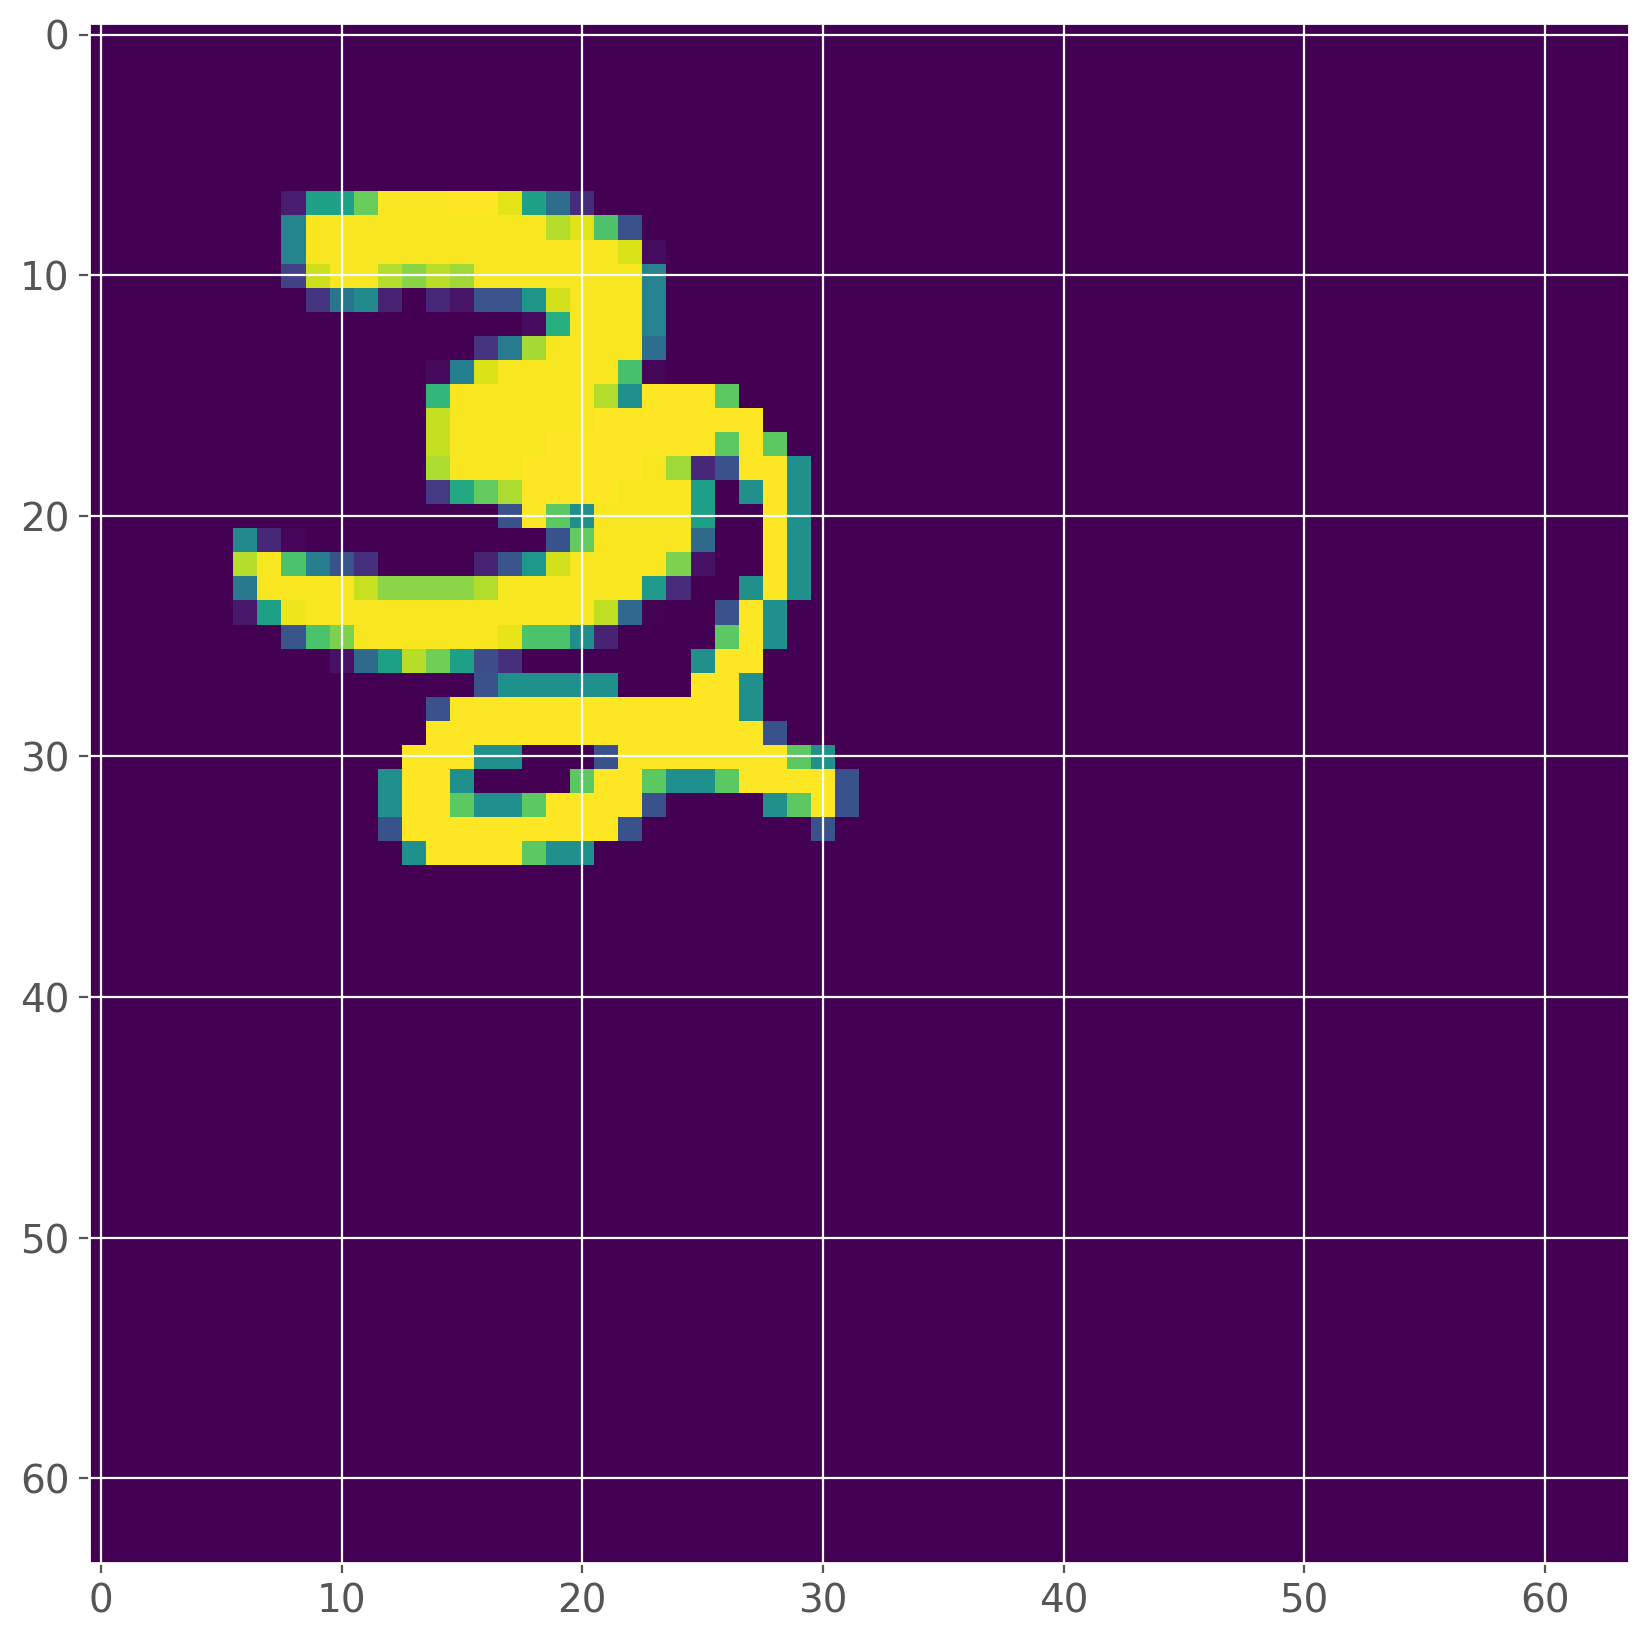

In [57]:
plt.imshow(y_batch[0,0,0,:,:])